# Off-policy Monte Carlo
- Algorithms from ```pp. 84 - 92``` in Sutton & Barto 2017
    - Off-policy prediction via importance sampling
    - Off-policy MC control

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn

from gridWorldEnvironment import GridWorld

In [2]:
# creating gridworld environment
gw = GridWorld(gamma = .9)

### Generate functions for generating policy

In [3]:
def generate_any_policy(env):
    pi = dict()
    for state in env.states:
        r = sorted(np.random.sample(3))
        actions = env.actions
        prob = [r[0], r[1] - r[0], r[2] - r[1], 1-r[2]]
        pi[state] = (actions, prob)
    return pi    

In [4]:
def generate_random_policy(env):
    pi = dict()
    for state in env.states:
        actions = []
        prob = []
        for action in env.actions:
            actions.append(action)
            prob.append(0.25)
        pi[state] = (actions, prob)
    return pi

In [5]:
def generate_greedy_policy(env, Q):
    pi = dict()
    for state in env.states:
        actions = []
        q_values = []
        prob = []
        
        for a in env.actions:
            actions.append(a)
            q_values.append(Q[state,a])   
        for i in range(len(q_values)):
            if i == np.argmax(q_values):
                prob.append(1)
            else:
                prob.append(0)       
                
        pi[state] = (actions, prob)
    return pi

### Create Action Values
- Initialize all state-action values with 0

In [6]:
def state_action_value(env):
    q = dict()
    for state, action, next_state, reward in env.transitions:
        q[(state, action)] = np.random.random()
    return q

In [7]:
def weight_cum_sum(env):
    c = dict()
    for state, action, next_state, reward in env.transitions:
        c[(state, action)] = 0
    return c

### Generate episode
- Generate episode based on current policy ($\pi$)

In [8]:
def generate_episode(env, policy):
    episode = []
    done = False
    current_state = np.random.choice(env.states)
    action = np.random.choice(policy[current_state][0], p = policy[current_state][1])
    episode.append((current_state, action, -1))
    
    while not done:
        next_state, reward = gw.state_transition(current_state, action)
        action = np.random.choice(policy[current_state][0], p = policy[current_state][1])
        episode.append((next_state, action, reward))
        
        if next_state == 0:
            done = True
        current_state = next_state
        
    return episode

In [9]:
pi = generate_random_policy(gw)

### Off-policy MC Prediction
- Estimates $Q$ values

In [10]:
def off_policy_mc_prediction(env, pi, num_iter):
    Q = state_action_value(env)
    C = weight_cum_sum(env)
    
    for _ in range(num_iter):
        b = generate_any_policy(env)
        episode = generate_episode(gw, b)
        G = 0
        W = 1
        for i in range(len(episode)-1, -1, -1):
            s, a, r = episode[i]
            if s != 0:
                G = env.gamma * G + r
                C[s,a] += W
                Q[s,a] += (W / C[s,a]) * (G - Q[s,a])
                W *= pi[s][1][pi[s][0].index(a)] / b[s][1][b[s][0].index(a)]
                if W == 0:
                    break
                
    return Q

### Off-policy MC Control
- Finds optimal policy $pi \approx pi_*$

In [12]:
def off_policy_mc_control(env, pi, num_iter):
    Q = state_action_value(env)
    C = weight_cum_sum(env)
    pi = generate_greedy_policy(env, Q)
    
    for _ in range(num_iter):
        b = generate_any_policy(env)
        episode = generate_episode(gw, b)
        G = 0
        W = 1
        for i in range(len(episode)-1, -1, -1):
            s, a, r = episode[i]
            if s != 0:
                G = env.gamma * G + r
                C[s,a] += W
                Q[s,a] += (W / C[s,a]) * (G - Q[s,a])
                pi = generate_greedy_policy(env, Q)
                if a == pi[s][0][np.argmax(pi[s][1])]:
                    break
                W *= 1 / b[s][1][b[s][0].index(a)]

    return Q, pi

In [21]:
%%time
Q_hat, pi_hat = off_policy_mc_control(gw, generate_random_policy(gw), 1000)

Wall time: 1.51 s


In [22]:
# final policy obtained
pi_hat

{1: (['U', 'D', 'L', 'R'], [0, 0, 1, 0]),
 2: (['U', 'D', 'L', 'R'], [0, 1, 0, 0]),
 3: (['U', 'D', 'L', 'R'], [0, 1, 0, 0]),
 4: (['U', 'D', 'L', 'R'], [1, 0, 0, 0]),
 5: (['U', 'D', 'L', 'R'], [1, 0, 0, 0]),
 6: (['U', 'D', 'L', 'R'], [0, 0, 0, 1]),
 7: (['U', 'D', 'L', 'R'], [0, 0, 0, 1]),
 8: (['U', 'D', 'L', 'R'], [0, 0, 0, 1]),
 9: (['U', 'D', 'L', 'R'], [0, 0, 1, 0]),
 10: (['U', 'D', 'L', 'R'], [0, 0, 0, 1]),
 11: (['U', 'D', 'L', 'R'], [0, 1, 0, 0]),
 12: (['U', 'D', 'L', 'R'], [0, 0, 1, 0]),
 13: (['U', 'D', 'L', 'R'], [0, 0, 1, 0]),
 14: (['U', 'D', 'L', 'R'], [0, 0, 0, 1])}

### Visualizing policy

In [23]:
def show_policy(pi, env):
    temp = np.zeros(len(env.states) + 2)
    for s in env.states:
        a = pi_hat[s][0][np.argmax(pi_hat[s][1])]
        if a == "U":
            temp[s] = 0.25
        elif a == "D":
            temp[s] = 0.5
        elif a == "R":
            temp[s] = 0.75
        else:
            temp[s] = 1.0
            
    temp = temp.reshape(4,4)
    ax = seaborn.heatmap(temp, cmap = "prism", linecolor="#282828", cbar = False, linewidths = 0.1)
    plt.show()

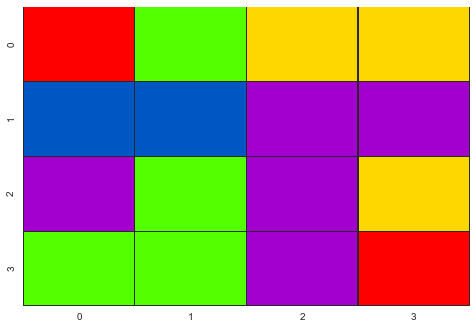

In [24]:
### RED = TERMINAL (0)
### GREEN = LEFT
### BLUE = UP
### PURPLE = RIGHT
### ORANGE = DOWN

show_policy(pi_hat, gw)